## Figure 2: Predicted joint evolution of dynamic topography and mantle temperature and Supplementary Video 1

In [2]:
import pygmt
import matplotlib.pyplot as plt
import os
import pygplates
import glob
import rioxarray as rxr
import xarray as xr
import pandas as pd
import numpy as np

In [3]:
# Function to transform longitude from 0-360 to -180 to 180
def transform_longitude(lon_360):
    return np.where(lon_360 > 180, lon_360 - 360, lon_360)
    

# Function to check and rename the longitude variable in the dataset
def check_and_process_longitude(ds):
    # List of possible longitude variable names
    possible_names = ['longitude', 'lon', 'x']
    
    # Check if any of the possible names exists in the dataset
    for name in possible_names:
        
        if name in ds:
            #print(f"Found longitude variable: '{name}'")
            # If the name is 'x' or any other name, rename it to 'longitude'
            if name != 'lon':
                print(f"Renaming '{name}' to 'lon'")
                ds = ds.rename({name: 'lon'})
            
            # Apply the longitude transformation
            if ds['lon'].values.min()>=0 or ds['lon'].values.max()>180:
                ds['lon'] = transform_longitude(ds['lon'].values)
    
            else:
                ds =ds
            ds = ds.sortby(['lon','lat'], ascending =True).drop_duplicates(dim =['lon', 'lat'])
            return ds
    # If no valid longitude variable is found, print a message
    print(f"Error: None of the following longitude variables were found: {', '.join(possible_names)}")
    return None  # Return None if no longitude variable is found

### Extract age from the mantlefraem grid files and sort file paths by age

In [4]:
import re

def sort_files_by_age(fpaths, match_string='Ma'):
    """
    This function extracts ages from file paths and sorts them (reverse/)chronologically.

    Parameters:
    fpaths: list of file paths
    match_string: the string to match before the age (default is 'Ma')

    Returns:
    Dictionary with the extracted age as the key and the sorted file paths as values
    """
    # Use a generator to extract ages and pair them with file paths
   
    def extract_age(file_name):
        match = re.search(f'{match_string}(\d+).', file_name)
        return int(match.group(1)) if match else float('inf')  # return inf if no match is found

    # Sort the file paths by the extracted age using a generator expression
    sorted_files = sorted(fpaths, key=lambda x: extract_age(x))
    
    # Return a dictionary with the age as the key and the file path as the value
    return {extract_age(file): file for file in sorted_files}

### Handle shapefiles' geometry and process coordinates to 0-360 system

In [5]:
import geopandas as gpd
from pyproj import CRS
from shapely.geometry import Point, LineString, Polygon, MultiLineString, MultiPoint, MultiPolygon
from shapely.ops import unary_union
import math
def adjust_longitude(geometry, f_name):
    # For Points
    if isinstance(geometry, Point):
        x, y = geometry.x, geometry.y
        if x < 0:  # if longitude is negative
            x += 360
        return Point(x, y)

    # For LineString
    elif isinstance(geometry, LineString):
        return LineString([(x + 360 if x < 0 else x, y) for x, y in geometry.coords])

    # For Polygon
    elif isinstance(geometry, Polygon):
        return Polygon([(x + 360 if x < 0 else x, y) for x, y in geometry.exterior.coords])

    # For MultiPoint
    elif isinstance(geometry, MultiPoint):
        return MultiPoint([Point(x + 360 if x < 0 else x, y) for x, y in geometry.coords])

    # For MultiLineString: Each line inside the MultiLineString needs to be handled individually.
    elif isinstance(geometry, MultiLineString):
        if '_polyline' in f_name:
            print(f_name, True)
            adjusted_lines =   [adjust_longitude(line, f_name) for line in geometry.geoms]
            merged_coords=[]
            for ls in adjusted_lines:
                merged_coords.extend(list(ls.coords))
                #print(f"Polyline:", min(list(ls.coords)), max(list(ls.coords)))
            return LineString(merged_coords)
        else:
            #print("no polyline in filename", filename)
            return MultiLineString([adjust_longitude(line, f_name) for line in geometry.geoms])

    # For MultiPolygon: Each polygon inside the MultiPolygon needs to be handled individually.
    elif isinstance(geometry, MultiPolygon):
        return MultiPolygon([
            Polygon([(x + 360 if x < 0 else x, y) for x, y in polygon.exterior.coords]) for polygon in geometry.geoms
        ])

    # If geometry is none of the above (should not happen in most cases)
    return geometry


### Create transect polyline from great circle points and reconstruct transect for mantle flow model 

In [19]:

import cartopy.crs as ccrs
def polyline_rotation(model, polyline, age, name):
    """
    This function reconstructs the transect for specified mantle flow model's reconstruction.

    Parameters:
    model: manlte flow model (string)
    polyline: transect shapefile 
    age: specified reconstruction time (in Ma)
    name: topology name (string)

    Returns:
    reconstructed shapefile
    """
    
    #static_polygons = f'.././Reconstructions/shapes_static_polygons_Merdith_et_al.gpml'
    static_polygons = f'/Reconstructions/shapes_static_polygons_Merdith_et_al.gpml'
        
    if model == 'gld428':
        input_rotation_filenames = [
            f'Reconstructions/For_{model}/NR_0Ma_1000Ma_for_gplates.rot',
            f'Reconstructions/For_{model}/1000_410_rotations_NNR.rot',
            f'Reconstructions/For_{model}/Global_EB_250-0Ma_GK07_2017-NNR.rot',
            f'Reconstructions/For_{model}/Global_EB_410-250Ma_GK07_2017-NNR.rot',
        ]
        topology_filenames ={
            'COB' : ['Reconstructions/For_gld428/shapes_continents_Merdith_et_al.gpml',
                     'Reconstructions/For_gld428/shapes_cratons_Merdith_et_al.gpml',
                     
                    ],
            'Divergence': ['Reconstructions/For_gld428/1000_410_Divergence_NNR.gpml'],
            'Transforms' :['Reconstructions/For_gld428/1000_410_Transforms_NNR.gpml'],
            'Convergence': ['Reconstructions/For_gld428/1000_410_Convergence_NNR.gpml'],
            'Plate_boundaries' : ['Reconstructions/For_gld428/Global_EarthByte_Paleozoic_plate_boundaries_2016_v5_F_NNR.gpml',
                     'Reconstructions/For_gld428/Global_EarthByte_Mesozoic-Cenozoic_plate_boundaries_2016_v5_NNR.gpml',
                                 ],
            'Topologies': ['Reconstructions/For_gld428/1000_410_Topologies_NNR.gpml',
                           'Reconstructions/For_gld428/TopologyBuildingBlocks_AREPS_NNR.gpml'
                          ],
            
        }  
        
    elif model == 'gld504':
        input_rotation_filenames = [
            f'Reconstructions/For_{model}/1000_0_rotfile_Merdith_et_al_slightly_changed_for_nnr_nico_mod.rot',
            f'Reconstructions/For_{model}/NR_0Ma_1000Ma_for_gplates_combine.rot' 
                                   ]
        topology_filenames =  {
            'COB':['Reconstructions/For_gld504/COBfile_1000_0_combined_by_xianzhi.gpml'],
            'Divergence': ['Reconstructions/For_gld504/1000_410_Divergence_Merdith_et_al.gpml'],
            'Transforms' : ['Reconstructions/For_gld504/1000_410_Transforms_Merdith_et_al.gpml'],
            'Convergence' : ['Reconstructions/For_gld504/1000_410_Convergence_Merdith_et_al.gpml'],
            #'Plate_boundaries' : ['./Reconstructions/For_gld504/250_0_plate_boundaries_Merdith_et_al.gpml',
            #                      './Reconstructions/For_gld504/410_250_plate_boundaries_Merdith_et_al.gpml'],
            # 'Topologies' : ['./Reconstructions/For_gld504/1000_410_Topologies_Merdith_et_al.gpml',
            #                 './Reconstructions/For_gld504/TopologyBuildingBlocks_Merdith_et_al.gpml'],
            
        }
        
    rotation_model = pygplates.RotationModel(input_rotation_filenames)

    anchor_plate_id = int(0)
        
    sp = pygplates.FeatureCollection(static_polygons)

    outfile_dir = f'./topologies_reconstructed/{model}'
    if not os.path.exists(outfile_dir):
        os.makedirs(outfile_dir)
   
    for fname, topo in topology_filenames.items():

        topology_features = pygplates.FeatureCollection()
        for topology_filename in topo:
            topology_features.add(pygplates.FeatureCollection(topology_filename))

        if fname == 'Convergence':
            #print(True)
            filename =f'{outfile_dir}/{model}_convergence.shp'
            file_seg = f'{outfile_dir}/{model}_convergence_fileseg.shp'
            pygplates.reconstruct(topology_features, rotation_model, filename, age)
            pygplates.resolve_topologies(topology_features, rotation_model, file_seg, age, file_seg) 
        else: 
            if age == 0 and fname=='COB':
                
                filename =f'{outfile_dir}/{model}_reconstructed_{fname}_{age}.shp'
            else:
                filename =f'{outfile_dir}/{model}_reconstructed_{fname}.shp'
            pygplates.reconstruct(topology_features, rotation_model, filename, age)
    
        #open shapefile and then convert -180 to 180 system to 0-360 system
        #large gpml filenames and filenames with space,- and other characters are not accepted
        if os.path.exists(filename):
            new_file = gpd.read_file(filename)
            # Apply the function to each geometry in the GeoDataFrame
            new_file['geometry'] = new_file['geometry'].apply(adjust_longitude, args =(filename,))
            new_file.to_file(filename)
    
    output_polyline =f'{outfile_dir}/{model}_reconstructed_polyline_{name}.shp'
    polyline_recon = pygplates.reconstruct(polyline, rotation_model, output_polyline, age)

    new_polyline_recon = gpd.read_file(output_polyline)
    new_polyline_recon['geometry'] = new_polyline_recon['geometry'].apply(adjust_longitude, args=(output_polyline,))
    new_polyline_recon.to_file(output_polyline)
    #fxy.to_csv(output_polyline, index=False)
    return output_polyline


### Postprocess reconstructed transect polyline to list of geodataframe 

In [7]:
#process points to get 
import geopandas as gpd
def reconstructed_polyline_to_points(recon_polyline):
    """
    This function transforms the reconstructed transect polyline to list of points [GeoDataFrame].

    Parameters:
    recon_polyline: shapefile [reconstructed polyline (transect)]

    Returns:
    GeoDataFrame [ list of points ]
    """
    lats = []
    lons = []
    if isinstance(recon_polyline, str) and os.path.isfile(recon_polyline):
        if '.xy' in recon_polyline:
            print('saved as .xy')
            g = pd.read_csv(recon_polyline, header=0).rename({'x':'r', 'y':'s'}, axis=1)
            return g
        else:
            geom =gpd.read_file(recon_polyline).geometry
            print(geom)
    elif isinstance(recon_polyline, gpd.GeoDataFrame):
        print('Instance is GeoDataFrame')
        geom = recon_polyline.geometry
    for line in geom:
        # Get coordinates from each LineString
        coords = list(line.coords)
        lons.append([coord[0] for coord in coords])
        lats.append([coord[1] for coord in coords])
    
    # Print extracted lats and lons
    dict = {'r':lons[0], 's':lats[0]}
    rotated_points = pd.DataFrame(dict)#.sort_values(by=['r','s'], ascending=True)
    diff = list(rotated_points['r'].diff())
    cleaned_diff = [abs(x) for x in diff[1:]]
    #print([round(v,1) for v in rotated_points.r])
    if max(cleaned_diff) > 40:
        print( 'abrupt jump found')
        # Find index of max value
        max_idx = rotated_points['r'].idxmax()
        #print('max_idx:',max_idx)
        # Check if max value is in the last row
        if max_idx != rotated_points['r'].index[-1]:
            # Add 360 to all values below the max index
            rotated_points.loc[max_idx+1:,'r' ] += 360
        #rotated_points.drop('diff', axis=1)
    
    return rotated_points

### Create transect from specified center and endpoint along the great circle 

In [8]:
def create_xsection_points_polyline(center=None, endpoint=None):
    """
    Takes in the two endpoints and then creates a line(series of points) along the great circle.
    ceter: [lon, lat] - starting point
    endpoint : [lon, lat] - end point
    returns : dataframe with r, s and polyline
    """
    
    points = pygmt.project(center=center, endpoint=endpoint, generate="0.15")
    points['nd_radius'] = 1.00
    pointsb= points[['s','nd_radius']]

    points['r'] = points['r'].apply(lambda  x : (x+360)%360)
    points_pyg = [
    pygplates.PointOnSphere((lat, lon))
        for lon, lat in zip(points.r, points.s)
    ]
    polyline = pygplates.PolylineOnSphere(points_pyg)

    #create reconstructalbe polyline
    feat = pygplates.Feature.create_reconstructable_feature(
    pygplates.FeatureType.gpml_geological_lineation,
    polyline,
    name='NA',
    valid_time=(1000, pygplates.GeoTimeInstant.create_distant_future()),
    reconstruction_plate_id=101)
    
    return points, feat

### Reconstruct boundaries (static polygons) and extract centroids and outer boundary and label them 

In [20]:
import gplately
from shapely.validation import make_valid

def label_position_reconstruct(row, age):
    """
    Takes in the boundary (geometry of static polygon) and age, renconstruct to specified age and returns cetriod of the reconstructed polygon.
    row: GeoDataFrame row including geometry 
    returns : dataframe with r, s and polyline
    """
    
    model ='gld504'
    input_rotation_filenames = [
                f'Reconstructions/For_{model}/1000_0_rotfile_Merdith_et_al_slightly_changed_for_nnr_nico_mod.rot',
                f'Reconstructions/For_{model}/NR_0Ma_1000Ma_for_gplates_combine.rot' 
                                       ]
    topology_features= ['Reconstructions/For_gld504/1000_410_Topologies_Merdith_et_al.gpml']
    #['./Reconstructions/For_gld504/COBfile_1000_0_combined_by_xianzhi.gpml']
    static_polygons =['Reconstructions/shapes_static_polygons_Merdith_et_al.gpml']
    model_labelrot = gplately.PlateReconstruction(input_rotation_filenames, topology_features, static_polygons)
    multipolygon = row['geometry']
    coordinates = gpd.GeoSeries([multipolygon]).get_coordinates()
    # point = row.geometry.representative_point()
    # x, y = point.x, point.y  
    x = coordinates.x.mean()
    y = coordinates.y.mean()
    gpts = gplately.Points(model_labelrot, [x], [y])
    r_x, r_y = gpts.reconstruct(age, return_array=True)
    return r_x, r_y



def topology_merge_label(cobs_path):
    
    def map_plateid(val):
        for k, v in mapping.items():
            if str(val).startswith(k):
                return v
        return None

    mapping ={
        '101':'LAU',
        #'50': 'IN',
        '601':'NCC',
        #'602':'SC',
        '7703' : 'KAL',
        '701' : 'CON',
        '77144' : 'WAC',
        '803':'ANT',
        '802' : 'ANT',
        '206': 'SF',
        '2205': 'SF',
        '8011': 'AUS',
        '201': 'AMZ',
        #'26' :'AN',
        '302': 'BAL',
        '401' :'SIB',
        
        
    }
    cobs= gpd.read_file(cobs_path)
    
    cobs['LABEL'] = cobs['PLATEID1'].apply(lambda x: map_plateid(x) )
    cobs['geometry'] = cobs['geometry'].apply(make_valid)
    dissolved_cobs = cobs.dissolve(by='LABEL').reset_index()
    
    return dissolved_cobs

    
# extract only exterior polygon of multipolygon cobs
def extract_outer(gdf_path, group_col):

    gdf = gpd.read_file(gdf_path)
    gdf_proj = gdf.to_crs(epsg=6933)

    largest_polys = []
    for group_val, group_df in gdf_proj.groupby(group_col):
        largest_poly = group_df.loc[group_df.geometry.area.idxmax()]
        largest_polys.append(largest_poly)

    # Return results back in original CRS
    result = gpd.GeoDataFrame(largest_polys, columns=gdf.columns, crs=gdf_proj.crs)
    return result.to_crs(gdf.crs)

def filter_largepolygons(gdf, a_thres=0.2):
    # Ensure GeoDataFrame is in a projected CRS
    if gdf.crs.is_geographic:
        gdf = gdf.to_crs(epsg=3857)  # Use a projected CRS for accurate area calculation
    
        # Calculate areas
        areas = gdf.geometry.area
        
        # Compute 10% of the maximum area
        threshold = a_thres * areas.max()
        
        # Filter polygons with area greater than this threshold
        filtered_gdf = gdf[areas > threshold]
        return filtered_gdf.to_crs(4326)

# example run

# model ='gld504'
# outer_cob = extract_outer(f'./topologies_reconstructed/{model}/{model}_reconstructed_COB.shp', 'PLATEID1')
# outer_cobs = filter_largepolygons(outer_cob, 0.015)
# outer_cobs.plot(facecolor='None')

### Load mantle flow (velocity) profiles [vx, vy, vz]

In [21]:
def load_merge_velocity(model, age):
    
    """
    Read depthwise velocity files in x, y and z dimension, merge them into a dataset,
    and compute azimuth and vector length.

    Parameters
    ----------
    files : list of str
        Paths to fragmented velocity files (NetCDF).
    model : str
        Variable names for velocity components.
    age : str|int
        Dimension to concatenate along (default: "time").
    c

    Returns
    -------
    ds : xr.Dataset
        Merged dataset with vx, vy and vz.
    """

    velocity_variables = ['vx','vy', 'vz']

    vel_datasets =[]

    # scaling factor: K/Radius * u' [thermal diffusivity (1e-6)/Radius of Earth (6371km)  unit conversion to cm/year]
    scaling_factor = (1e-6 /6371000)*(100 * 365*24*3600)

    for vel in velocity_variables:
        vel_files = glob.glob(f'.././Model_data/{model}/Velocity/*{vel}-{age}Ma*km.grd')
        sorted_vel_files = sort_files_by_age(vel_files, match_string = 'Ma-')
        depths = list(sorted_vel_files)
        velocity_dataset = xr.open_mfdataset(
                    sorted_vel_files.values(),
                    concat_dim=[
                        pd.Index(depths, name="depth"),
                    ],
                    #preprocess = check_and_process_longitude,
                    combine="nested",
                    join ='outer'
                ).rename({'lon':'x','lat':'y','z':vel})
        vel_datasets.append(velocity_dataset*scaling_factor)
    return xr.merge(vel_datasets)

def transect_grid(grid, df, var):
    """
    Extract and preprocess a subset of a gridded dataset along a transect.

    This function selects a subregion of the input grid based on the minimum 
    and maximum coordinates in the provided DataFrame, and prepares longitude 
    and latitude arrays for interpolation along a transect.

    Parameters
    ----------
    grid : xarray.Dataset or xarray.DataArray
        Gridded dataset containing variables defined on latitude/longitude coordinates.
    df : pandas.DataFrame
        DataFrame containing transect coordinates. Must have columns 'r' (longitude) 
        and 's' (latitude).
    var : str
        Name to use as the dimension label for the transect coordinates.

    Returns
    -------
    ds_filtered : xarray.Dataset or xarray.DataArray
        Subset of the original grid clipped to the bounding box defined by the 
        transect coordinates.
    n_lats : xarray.DataArray
        1D array of transect latitude values, with dimension `var`.
    n_lons : xarray.DataArray
        1D array of transect longitude values, with dimension `var`.

    Notes
    -----
    - This function does not perform interpolation itself, but prepares inputs 
      for later interpolation along the transect.
    - The bounding box is computed from the min/max of `df.r` and `df.s`.
    """
    

    region1 = [min(df.r), max(df.r),
                min(df.s),  max(df.s)
             ]

    
    #Preprocess data for interpolation 
    ds_filtered = grid.sel(x = slice(region1[0], region1[1]), y = slice(region1[2], region1[-1]))
    n_lats =xr.DataArray(df['s'], dims=var)
    n_lons = xr.DataArray(df['r'], dims=var)
    
    vtemp = ds_filtered.sel(y = n_lats, x= n_lons, method='nearest')
    vtemp.coords['depth'] = 1 - vtemp.coords['depth']/6317
    vtemp= vtemp.sortby(['depth', var]).drop_duplicates(dim =var)
    return vtemp

### Plot snapshot of coevolution of dynamic topography and mantle temperature at 640 Ma and 440 Ma

0    LINESTRING (258.52674 -67.99374, 258.89094 -68...
Name: geometry, dtype: geometry
0    LINESTRING (195.86533 -83.20911, 197.12697 -83...
Name: geometry, dtype: geometry
[2840, 2867] ['Temperature_and_Velocity/Temperature/gld504-temp-640Ma-2840km_mean_removed.grd', 'Temperature_and_Velocity/Temperature/gld504-temp-640Ma-2867km_mean_removed.grd']
max-vel:0.6399999856948853
0    LINESTRING (287.98267 -16.24111, 288.13295 -16...
Name: geometry, dtype: geometry
0    LINESTRING (297.04169 -34.2733, 297.01388 -34....
Name: geometry, dtype: geometry
[2840, 2867] ['Temperature_and_Velocity/Temperature/gld504-temp-440Ma-2840km_mean_removed.grd', 'Temperature_and_Velocity/Temperature/gld504-temp-440Ma-2867km_mean_removed.grd']
max-vel:0.6399999856948853
depth: 2677


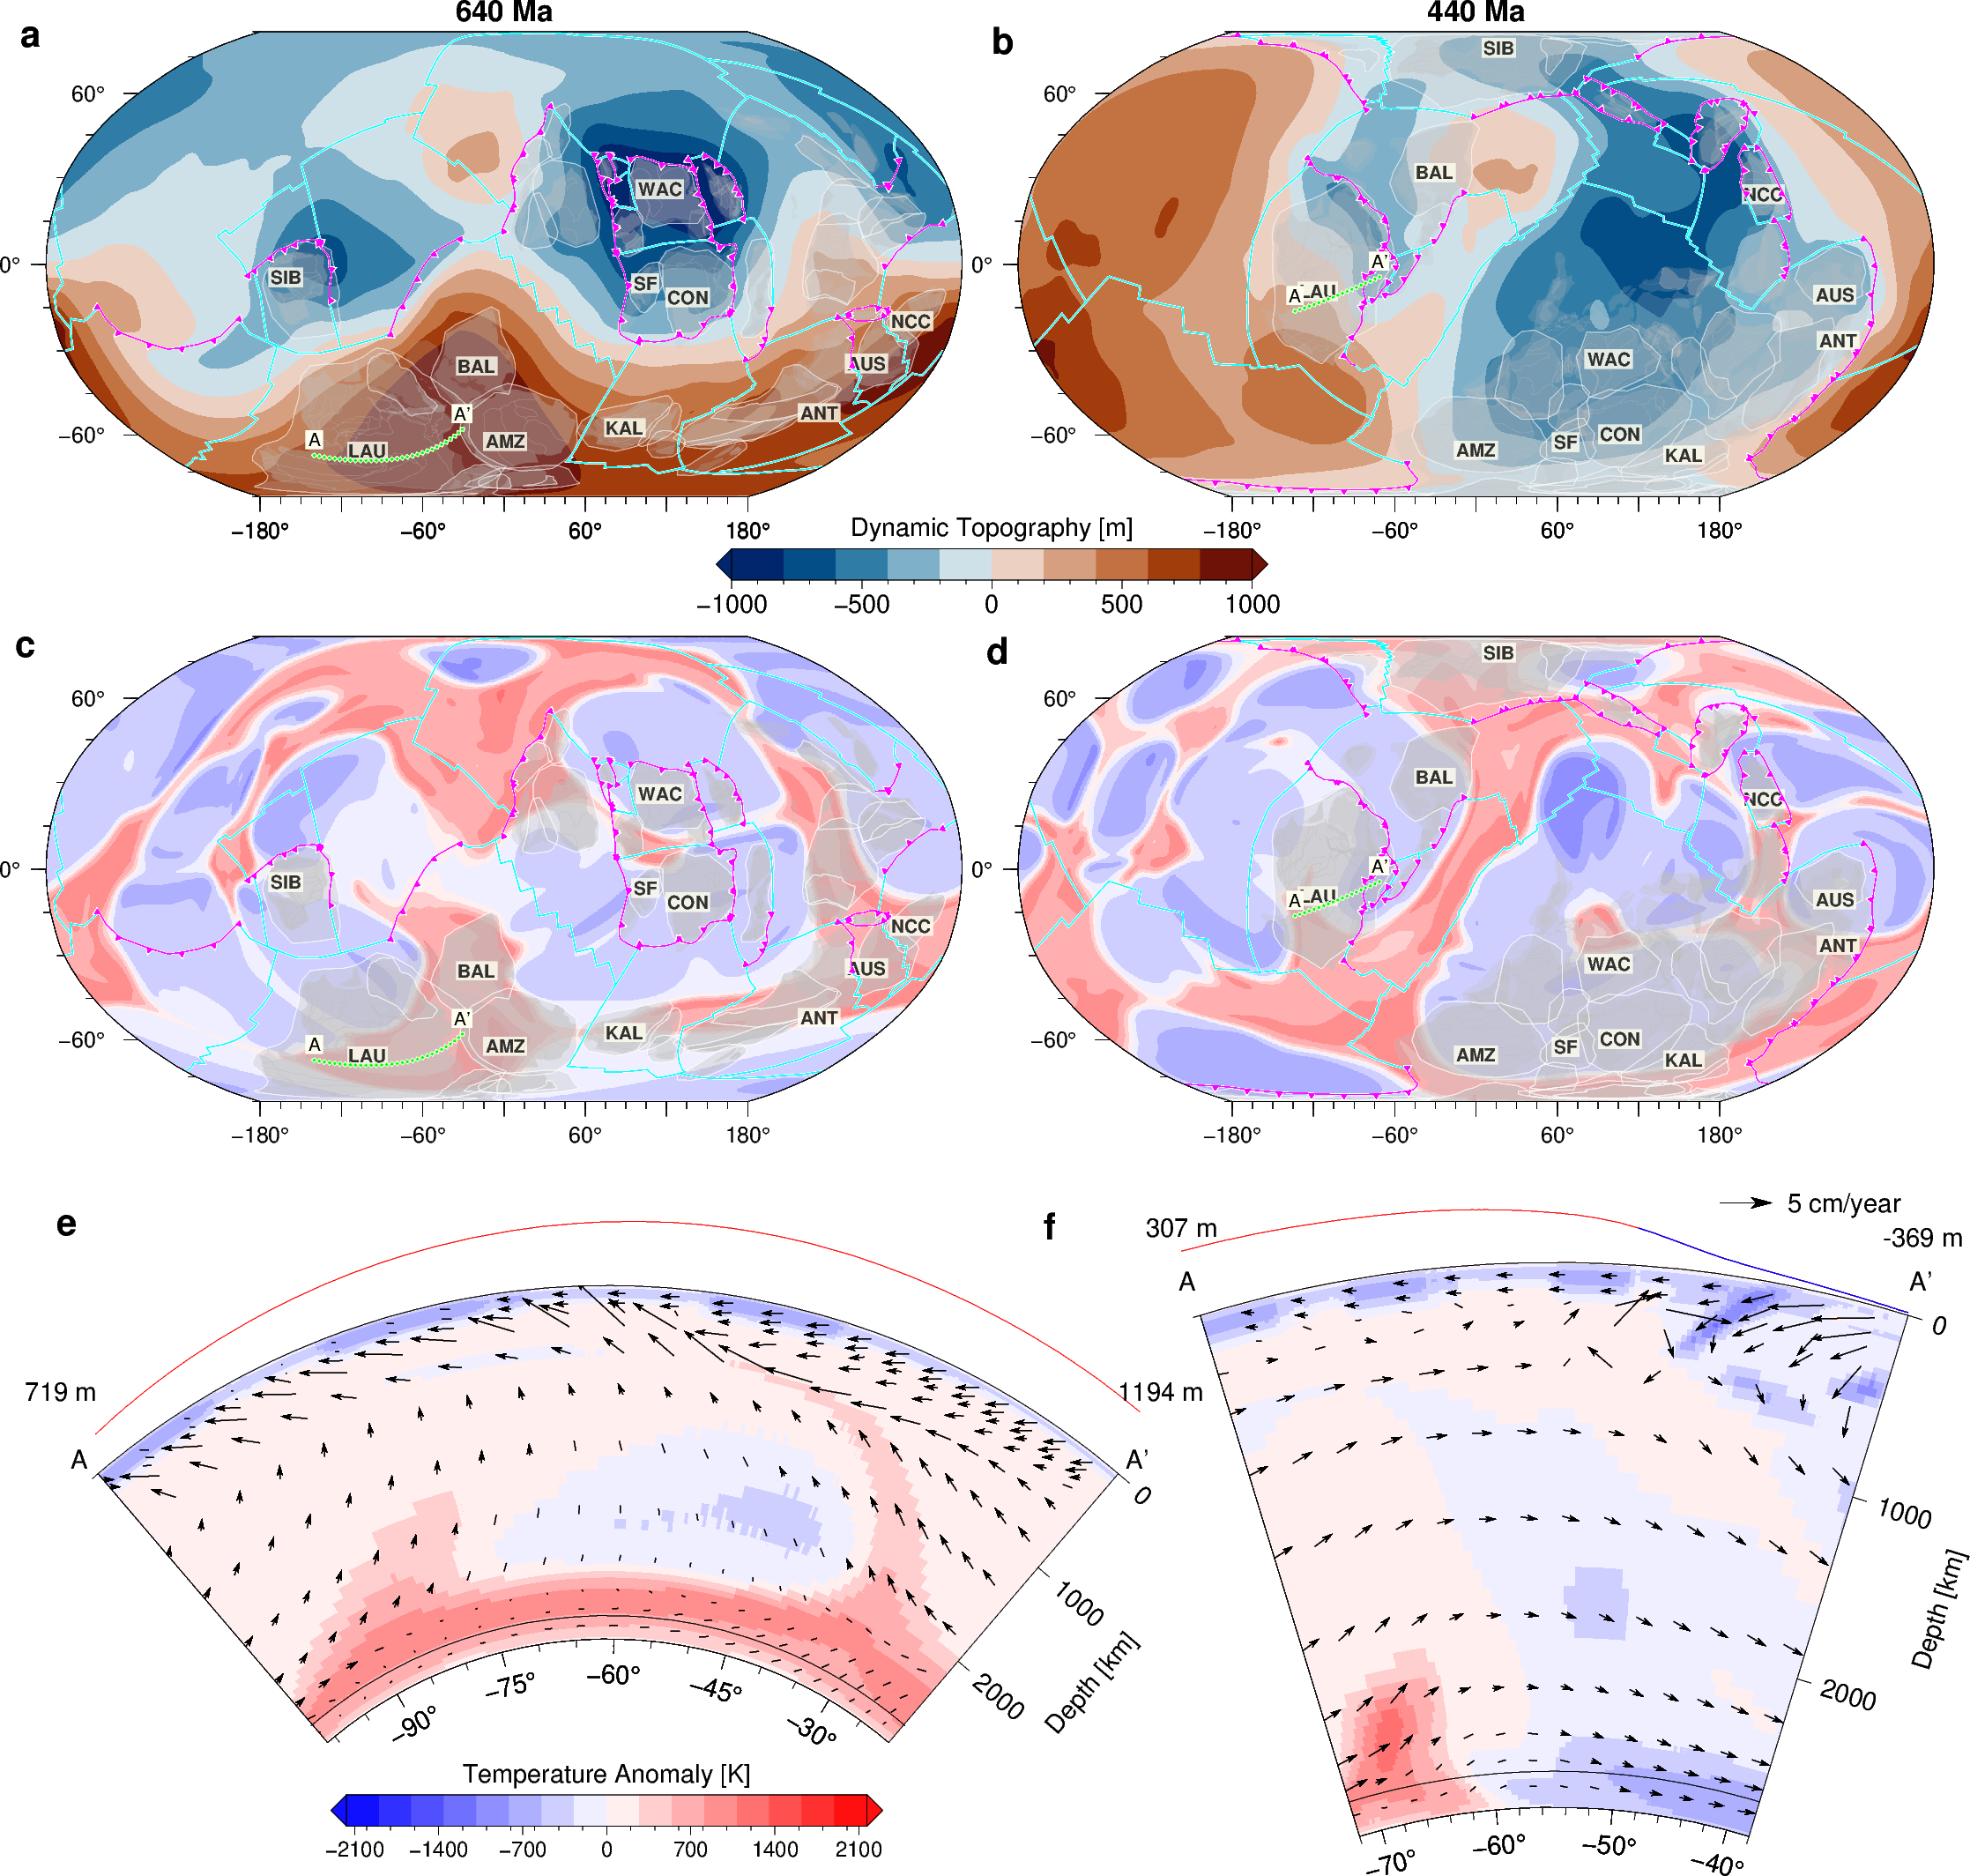

In [22]:
import io

# Clear warnings
pygmt.config(GMT_VERBOSE="q")

models =[ 'gld504']

for model in models:
    fig = pygmt.Figure()
    # fig config
    fig_width ="18c"
    fig_height = "16.75c"
    subplot_depth ="8.8c"
    seq_text = np.array([['a','b'], ['c', 'd'], ['e','f'],])
    with fig.subplot(
        nrows=3,
        ncols=2,
        figsize=(fig_width, fig_height),
    ):
        pygmt.config(FONT_TITLE="8p,Helvetica,black", FORMAT_GEO_MAP="D") #FONT_TITLE="8p,Courier,black", FORMAT_GEO_MAP="+D")
        #basedir = f'.././model_data/{model}/Temperature/ForSantosh' # for temperature files for 920–0 Ma
        basedir = f'Temperature_and_Velocity/Temperature' # for 440 and 640 Ma
            
        for j, age in enumerate([640, 440]):
            
            padding=3
            if len(str(age)) <= 2:
                age_str = str(age).zfill(padding)
                print(age_str)
            else:
                age_str = age
    
            #crossection lines processing
            points_x, polyline_x = create_xsection_points_polyline(center=[-110, 43], endpoint=[-60, 45])
            points_y, polyline_y = create_xsection_points_polyline(center=[-100, 25], endpoint=[-105, 60])
            
            polyline_x_reconstructed = polyline_rotation(model, polyline_x, age, 'x')
            polyline_y_reconstructed = polyline_rotation(model, polyline_y, age, 'y')
            
            rotated_points_x = reconstructed_polyline_to_points(polyline_x_reconstructed)
            #print(rotated_points_x.head())
            rotated_points_y = reconstructed_polyline_to_points(polyline_y_reconstructed)
            points_list = [rotated_points_x, rotated_points_y]
    
            #Temperature Anamoly
            temp_files = glob.glob(f'{basedir}/*-{age_str}Ma*.grd')
            #print(temp_files[-2:])
            sorted_tempfiles = sort_files_by_age(temp_files, match_string = 'Ma-')
            print(list(sorted_tempfiles.keys())[-2:],list(sorted_tempfiles.values())[-2:])
            
            das = list(sorted_tempfiles.values())
            depths = list(sorted_tempfiles.keys())
            
            ds_orgs = xr.open_mfdataset(
                das,
                concat_dim=[
                    pd.Index(depths, name="depth"),
                ],
                #preprocess = check_and_process_longitude,
                combine="nested",
                join ='outer'
            )
            ds = ds_orgs.rename({'lon':'x', 'lat':'y'}).z
            if points_list[0]['r'].max()> 360:
                print('Dataset is extended and stitched together')
                ds_360 = ds.assign_coords(x=ds.x + 360)
                ds_extended = xr.concat([ds, ds_360], dim='x').drop_duplicates(dim=['x','depth'])
            else:
                ds_extended=ds
            
            #crossectional depth for the first plot
            depth =-8
            #bms_depth = slice(1000, 2800)
            texts =[['A',"A'"],['C', "C'"]]
            #cmap
            cmap ='temp_polar3.cpt'
            
            region1 = [min(points_list[0].r), max(points_list[0].r),
                        min(points_list[0].s),  max(points_list[0].s)
                     ]
           
            region =[-180,180,-90,90]
            
            proj_lon = int(min(points_list[0].r)+ (max(points_list[0].r) -min(points_list[0].r))/2)
            proj_lat = int (min(points_list[0].s)+ (max(points_list[0].s)- min(points_list[0].s))/2)                                 
            
            projection = f"N8.8c" 
            cobs_path = f'./topologies_reconstructed/{model}/{model}_reconstructed_COB.shp'
            COBS = topology_merge_label(cobs_path)
            with fig.set_panel(panel=[1,j], clearance =['s0c']):
                
                pygmt.config( MAP_FRAME_PEN="0.01", FONT_TITLE="8p", FONT_HEADING ='16p', FONT_LABEL="8p", FONT_ANNOT="6p", FONT_ANNOT_PRIMARY="6p",MAP_TICK_PEN='0.01')
                #fig.grdimage(grid=ds.sel(depth=bms_depth,).mean(dim='depth', skipna=True), region=region, projection=projection, cmap=cmap) # for bms [averaged over 1000-2800km depth]
                fig.grdimage(grid=ds.isel(depth=depth,), region=region, projection=projection, cmap=cmap)
                fig.plot(f'./topologies_reconstructed/{model}/{model}_reconstructed_COB.shp', projection = projection, region=region, fill ='grey', transparency =70 )
                
                #outer polygon lines
                outer_cob = extract_outer(f'./topologies_reconstructed/{model}/{model}_reconstructed_COB.shp', 'PLATEID1')
                outer_cob = filter_largepolygons(outer_cob, 0.01)
                fig.plot(data=outer_cob, region=region, projection=projection, pen="0.01, white", transparency=20)

                #Plot paleocontinents labels
                cobs_path = f'./topologies_reconstructed/{model}/{model}_reconstructed_COB_0.shp'
                #cobs_path = f'./topologies_recon/gld504/topology_boundaries_0.00Ma.shp'
                COBS = topology_merge_label(cobs_path)
                for _, row in COBS.iterrows():
                    # Get a point that is guaranteed to be inside the polygon
                    r_x, r_y = label_position_reconstruct(row, age)
                    label = row["LABEL"] # or any label field you want
                    if label=='ANC':
                        r_x = r_x -20
                        r_y= r_y+5
                    #fig.text(x=x, y=y, text=label, font="3p,Helvetica,black, bold", justify="CM", region=region, projection=projection)
                    fig.text(x=r_x, y=r_y, text=label, font="5p,Helvetica-Bold,black",fill='ivory', transparency=20, justify="CM", region=region, projection=projection, verbose='q')
            
                #white margins
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_ridge_transform_boundaries_{age}.00Ma.shp', projection = projection, region =region, pen ="0.4p, white")
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_subduction_boundaries_sL_{age}.00Ma.shp', projection = projection, region =region, pen ="0.3p, white", style="f0.3c/0.065c+l+t", fill='white',)
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_subduction_boundaries_sR_{age}.00Ma.shp', projection = projection, region =region, pen ="0.3p, white", style="f0.3c/0.065c+r+t", fill='white',)

                #regular plot
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_ridge_transform_boundaries_{age}.00Ma.shp', projection = projection, region =region, pen ="0.1p, cyan")
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_subduction_boundaries_sL_{age}.00Ma.shp', projection = projection, region =region, pen ="0.05p, magenta", style="f0.3c/0.05c+l+t", fill='magenta',)
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_subduction_boundaries_sR_{age}.00Ma.shp', projection = projection, region =region, pen ="0.05p, magenta", style="f0.3c/0.05c+r+t", fill='magenta',)
                #fig.plot(x=rotated_points_y.r, y=rotated_points_y.s, projection =projection, pen="0.5p,black",)
                fig.plot(polyline_x_reconstructed, projection =projection, pen ='0.01p,ivory1', style="f0.05c/0.05c+t", fill='green',)
                #fig.plot(polyline_y_reconstructed, projection =projection, pen ='1p,ivory1', style="f1c/0.3c+t", fill='ivory1')

                
                fig.text(
                        x=[points_list[0]['r'].iloc[0], points_list[0]['r'].iloc[-1]],
                            #y=[points_list[i]['s'].max()+0.01,  points_list[i]['s'].min()+0.01],
                        y=[points_list[0]['s'].iloc[0], points_list[0]['s'].iloc[-1]],
                            text=texts[0],
                            no_clip=True,  # Do not clip text that fall outside the plot bounds
                            #font="10p,Helvetica", # Use a font size of 10 points
                            #pen ="0.01,black",
                            fill = 'ivory1',
                            font ="5p,Helvetica,black",
                            offset ="0/0.15",
                            #panel =[0,0],
                            projection =projection
                        )  
            
                fig.text(
                    text=seq_text[1,j],
                    position="TL",  # Top Left
                    justify="TL",  # Top Left
                    offset="-0.3c/-0.3c",
                    no_clip=True, 
                    font="10p,Helvetica-Bold,black"
                )
                
                fig.basemap(frame=[f"rWts", f"xaf"], region=region, projection =projection)

            #----------------------------------------------Dynamic topography plot-----------------------------------------------#
            with fig.set_panel(panel=[0,j]):
                pygmt.config(MAP_FRAME_TYPE="plain", MAP_FRAME_PEN="0.01", FONT_TITLE="8p, Helvetica-Bold", FONT_HEADING ='16p', FONT_LABEL="8p", FONT_ANNOT="6p", FONT_ANNOT_PRIMARY="6p",MAP_TITLE_OFFSET ="-0.3c",MAP_TICK_PEN='0.01')
                
                #dt_file =xr.open_dataset(f'.././Model_data/{model}/Latitude_correction_before_removing_DT_mean/{model}NLt-{age}.topo_corr.0.grd') #xr.open_dataset(f'./Model_data/{model}/MantleFrame/{model}NLt-{age}.topo_corr.0.grd')
                dt_file =xr.open_dataset(f'Temperature_and_Velocity/{model}NLt-{age}.topo_corr.0.grd')
                series = [-1000, 1000, 200] #[int(dt_file.z.values.min()), int(dt_file.z.values.max())]
                pygmt.makecpt(cmap="SCM/vik",series=series, background=True)
                fig.grdimage(grid=dt_file.z, projection=projection, cmap=True, region=region, )
                fig.plot(f'./topologies_reconstructed/{model}/{model}_reconstructed_COB.shp', projection = projection, region=region, fill ='grey', transparency=80)
                #fig.plot(COBS, projection = projection, pen ="0.02p, black",region=region, fill ='green', transparency=80)

                outer_cob = extract_outer(f'./topologies_reconstructed/{model}/{model}_reconstructed_COB.shp', 'PLATEID1')
                outer_cob = filter_largepolygons(outer_cob, 0.01)
                fig.plot(data=outer_cob, region=region, projection=projection, pen="0.01, white", transparency=40)

                #Plot paleocontinents labels
                cobs_path = f'./topologies_reconstructed/{model}/{model}_reconstructed_COB_0.shp'
                #cobs_path = f'./topologies_recon/gld504/topology_boundaries_0.00Ma.shp'
                COBS = topology_merge_label(cobs_path)
                for _, row in COBS.iterrows():
                    # Get a point that is guaranteed to be inside the polygon
                    
                    r_x, r_y = label_position_reconstruct(row, age)
                    label = row["LABEL"] # or any label field you want
                    if label=='ANC':
                        r_x = r_x -20
                        r_y= r_y+5
                    #fig.text(x=x, y=y, text=label, font="3p,Helvetica,black, bold", justify="CM", region=region, projection=projection)
                    fig.text(x=r_x, y=r_y, text=label, font="5p,Helvetica-Bold,black",fill='ivory', transparency=20, justify="CM", region=region, projection=projection, verbose='q')
                #white margins
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_ridge_transform_boundaries_{age}.00Ma.shp', projection = projection, region =region, pen ="0.4p, white")
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_subduction_boundaries_sL_{age}.00Ma.shp', projection = projection, region =region, pen ="0.3p, white", style="f0.3c/0.065c+l+t", fill='white',)
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_subduction_boundaries_sR_{age}.00Ma.shp', projection = projection, region =region, pen ="0.3p, white", style="f0.3c/0.065c+r+t", fill='white',)

                #regular plot
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_ridge_transform_boundaries_{age}.00Ma.shp', projection = projection, region =region, pen ="0.1p, cyan")
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_subduction_boundaries_sL_{age}.00Ma.shp', projection = projection, region =region, pen ="0.05p, magenta", style="f0.3c/0.05c+l+t", fill='magenta',)
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_subduction_boundaries_sR_{age}.00Ma.shp', projection = projection, region =region, pen ="0.05p, magenta", style="f0.3c/0.05c+r+t", fill='magenta',)
                fig.plot(polyline_x_reconstructed, projection =projection, pen ='0.01p,ivory1', style="f0.05c/0.05c+t", fill='green', )
                #fig.plot(polyline_y_reconstructed, projection =projection, pen ='1p,ivory1', style="f1c/0.3c+t", fill='ivory1')

                
            
                fig.text(
                        x=[points_list[0]['r'].iloc[0], points_list[0]['r'].iloc[-1]],
                            #y=[points_list[i]['s'].max()+0.01,  points_list[i]['s'].min()+0.01],
                        y=[points_list[0]['s'].iloc[0], points_list[0]['s'].iloc[-1]],
                            text=texts[0],
                            no_clip=True,  # Do not clip text that fall outside the plot bounds
                            font ="5p,Helvetica,black",
                            offset = "0/0.15",
                            fill = 'ivory1',
                            #panel =[0,0],
                            projection =projection
                        )
                fig.text(text = seq_text[0, j], position="TL", no_clip=True, offset ="-0.25/-0.25", justify ="TL",font="10p,Helvetica-Bold,black")
                fig.basemap(frame=[f"lEtS+t{age} Ma", f"xaf"], region =region, projection =projection)

                #LEGEND
                
                if j==1:
                    pygmt.config( FONT_ANNOT_PRIMARY="12p", FONT_LABEL='12p', FONT_ANNOT='12p')
                    fig.colorbar(position="JBC+o-4.65c/0.5c+w5c/0.3c+e+h+ml",frame=[f"xaf+lDynamic Topography [m]"], projection=projection)
            
            if age<600:
                clearance =[ 's-1.25c', "w1.75c"]
                position="JTR+jTR+o0/-0.2c"
            else:
                clearance =["s-0.35c", "w0.5c"]
                position="JBR+jBR+o0/-0.2c"
            with fig.set_panel(panel =[2,j], clearance =clearance):
                    
                constant_dim ='longitude'
                if constant_dim =='latitude':
                    var ='y'
                    drop_vars='x'
                    r = 's'
                else:
                    var ='x'
                    drop_vars = 'y'
                    r='r'
                
                r_max = 1-max(depths)/6371
                r_min = 1
                
                #Preprocess data for interpolation 
                ds_filtered = ds_extended.sel(x = slice(region1[0], region1[1]), y = slice(region1[2], region1[-1]))
                n_lats =xr.DataArray(points_list[0]['s'], dims=var)
                n_lons = xr.DataArray(points_list[0]['r'], dims=var)
    
                vtemp = ds_filtered.sel(y = n_lats, x= n_lons, method='nearest')
                vtemp.coords['depth'] = 1 - vtemp.coords['depth']/6317
                vtemp= vtemp.sortby(['depth', var]).drop_duplicates(dim =var)
                
                n_depths = np.linspace(vtemp.depth.min(), vtemp.depth.max(), vtemp.depth.size *60)
                n_var = np.linspace(vtemp[var].min(), vtemp[var].max(), vtemp[var].size*10)
                vtemp= vtemp.interp(coords ={var: n_var, 'depth' :n_depths}, method='nearest')

                # dynamic topography
                if model=='gld504':
                    #dt_file =check_and_process_longitude(xr.open_dataset(f'./Model_data/{model}/MantleFrame/{model}NLt-800.topo_corr.0.grd'))
                    #dt_file =xr.open_dataset(f'.././Model_data/{model}/MantleFrame/{model}NLt-{age}.topo_corr.0.grd')  #org location
                    dt_file =xr.open_dataset(f'Temperature_and_Velocity/{model}NLt-{age}.topo_corr.0.grd')
                else:
                    dt_file =xr.open_dataset(f'.././Model_data/{model}/{model}NLt-{age}.topo_corr_05d.0.grd') 
                dt_css = dt_file.z.sel(lat =xr.DataArray(rotated_points_x.s, dims='lon'), lon= xr.DataArray(rotated_points_x.r, dims='lon'),  method='nearest').to_dataframe().reset_index().drop('lat', axis=1)
                dt_maxmin = {ind: values for ind, values in zip([dt_css.z.idxmax(), dt_css.z.idxmin()],[dt_css.z.max(), dt_css.z.min()])}
                
                #raiser = (1- dt_dataset.z.values.min())+0.02
                dt_css['z'] = dt_css.z.apply(lambda x:  (1 + x/(6371*2)))
                off_set = 1-dt_css.z.min()
                dt_css['z'] = dt_css.z.apply(lambda x:  x+ (1-dt_css.z.min()))
                #print(dt_css.z.min(), dt_css.z.max())
                inc = abs(1 - dt_css.z.values.max())
                #print(inc, off_set)
                dt_neg = dt_css[dt_css['z'] < (1 + off_set)]
                #dt_pos = dt_css[dt_css['z'] >=(1+off_set)]
                reg = [min(vtemp[var].values), max(vtemp[var].values), r_max, r_min]
                reg2=[min(vtemp[var].values), max(vtemp[var].values), 6371-max(depths), 6371]
                
                reg3 = [min(vtemp[var].values), max(vtemp[var].values), r_max, r_min+inc]
                reg4=[min(vtemp[var].values), max(vtemp[var].values), 6371-max(depths), 6371+inc*6371*2]
                
                
                central_line=min(vtemp[var].values)+(max(vtemp[var].values)-min(vtemp[var].values))/2
               
                if j==1:
                    proj = f"P6.8c/{round(central_line,2)}+a+t{round(central_line,2)}"
                    proj2 = f'P6.8c/{round(central_line,2)}+a+t{round(central_line,2)}+z'
                else:
                    proj = f"P9.8c/{round(central_line,2)}+a+t{round(central_line,2)}"
                    proj2 = f'P9.8c/{round(central_line,2)}+a+t{round(central_line,2)}+z'
            
                # define grid spacings for annotations based on the longitude spacings
                lon_spacing = max(points_list[0][r]) - min(points_list[0][r])
               # print(lon_spacing)
                
                if lon_spacing <=30:
                    annot = 10
                elif lon_spacing >30 and lon_spacing<=90:
                    annot = 15
                else:
                    annot = 30
                
                pygmt.config(MAP_FRAME_TYPE="plain", MAP_FRAME_PEN="0.01", FONT_ANNOT="7p", FONT_ANNOT_PRIMARY="7p", FONT_TITLE="7p", FONT_LABEL="7p", MAP_TICK_PEN='0.01',)
                fig.grdimage(grid=vtemp,region =reg, projection = proj, cmap=cmap, nan_transparent=True, frame=[ 'yf0.5'])#frame=[ "eSW", f"xa{annot}", "ya0.1+lDepth[km]",] )
                
                 #position="x5c/-1.2c+w4c/0.5c+jTC+h+e+ml"

                #-------------------------------------------------Load and Plot Velocity -----------------------------------------------#
                velocity_grid =load_merge_velocity(model, age)
                velocity_along_longitude = transect_grid(velocity_grid, points_list[0], var)
                resampled_vel = velocity_along_longitude .isel(x=slice(None, None, 10),
                              depth=slice(None, None, 5))
                u, v, w = resampled_vel.vx.values, resampled_vel.vy.values, resampled_vel.vz.values
                # Compute length (magnitude)
                length = np.sqrt(v**2 + w**2) /10 # scale it by number
                print(f'max-vel:{np.round(max(length.ravel()),2)}')
                
                # Compute azimuth (0° = north, clockwise)
                azimuth = (np.degrees(np.arctan2(w, v))+360) % 360
                
               
                vel_x, vel_depth = np.meshgrid(resampled_vel.x, resampled_vel.depth)
                vel_xyz = np.column_stack([vel_x.ravel(), vel_depth.ravel(), azimuth.ravel(), length.ravel()])
                
                   
                fig.plot(
                    x=vel_xyz[:, 0],          # longitude
                    y=vel_xyz[:, 1],          # latitude
                    direction=[vel_xyz[:,2],vel_xyz[:,3]],
                    style="v0.1c+e",     # or "V0.3c+e" for arrow head
                    pen="black",
                    fill="black",
                    projection = proj,
                    region=reg,
                    verbose='q',
                )
                # Manual legend 
                arrow_size = 5 * 0.1 
                vel_label= f'S 0.2c v {arrow_size:.2f}c black 0.05p 0.6c 5 cm/year'
                #0.1c v 0.25c magenta 0.5p 0.3c
                
                with open("legend.txt", "w") as f:
                    f.write(vel_label)
                if j==1:
                    fig.legend(spec='legend.txt', position="JRT+jRT+o0.9c/-0.85c+w1c",  projection =proj, box=False)
            
                #pygmt.makecpt(cmap="vik", series=[0, 32, 2], background=True)
                offsets =["0/0", "0/0"]#["-0.15/0", "0.15/0"]
                x_texts = [dt_css.lon.min() -0.1, dt_css.lon.max()+0.1] #[dt_css.lon.min()-0.25, dt_css.lon.max()+0.25]
                y_texts =[1.03,1.03]#[ vtemp.depth.values.max(), vtemp.depth.values.max()]
                #angles =[f"a{dt_css.lon.min()}", f"a{dt_css.lon.max()}"]
                
                for i, offset in enumerate(offsets):
                    fig.text(
                        x= [x_texts[i]],#[points_list[0][r].min()- 0.35, points_list[0][r].max() +0.35],
                        y= [y_texts[i]],
                        text=texts[0][i],
                        projection =proj,
                        #pen ='0.1, black',
                        offset=offset,
                        no_clip=True,
                        # Do not clip text that fall outside the plot bounds
                        #font="10p,Helvetica-Bold",
                        # Use a font size of 10 points
                    )  
                
                fig.plot(
                    region=reg,#[min(vtemp[var].values), max(vtemp[var].values),r_max, r_min],
                    projection=proj,
                    frame=None,
                    x= points_list[0][r],
                    y=[1 - depths[depth]/6371]* len(points_list[0][r]),
                    #y=[1.2]* len(points_africa.s),
                    pen="0.1p,black",
                    no_clip=True
                    
                )
                
                
                central_line_dt =min(dt_css.lon) + (max(dt_css.lon) - min(dt_css.lon))/2
                #Load dynamic topography, extract values to rotated points and plot on top of crosecctional plot
                if j==1:
                    
                    proj_dt1 =  [f'P6.8c/{round(central_line_dt,2)}+a+t{central_line_dt}']
                    proj_dt =  [f'P6.8c/{round(central_line_dt,2)}+a+t{central_line_dt}+z']
                else:
                    proj_dt1 =  [f'P9.8c/{round(central_line_dt,2)}+a+t{central_line_dt}']
                    proj_dt =  [f'P9.8c/{round(central_line_dt,2)}+a+t{central_line_dt}+z']

                # #dt plo
                fig.basemap(region=reg2, projection=proj2, frame=["SE", "ya+lDepth [km]", 'xa'])
                if j==0:
                    off ="0/0.4"
                    textoff =["0.2/0.6", "-0.15/0.6"]
                else:
                    off ="0/0.025"
                    textoff =["0/0.25", "0/0.15"]
                fig.plot(
                             x= dt_css['lon'],
                             y=dt_css['z'],
                             region=reg, 
                             projection=proj_dt1, 
                             pen='0.1p,red, solid',
                             offset=off,
                             no_clip=True,
                        )
                
                
                if not dt_neg.empty:
                    
                    fig.plot(
                             x= dt_neg['lon'],
                             y=dt_neg['z'],
                             region=reg, 
                             projection=proj_dt1, 
                             pen=f'0.2p,blue,solid',
                             offset=off,
                             no_clip=True,
                           
                             )

                offsets =["-0.4/0.5", "-1.5/0.0"]
                for tidx, (idx, val) in enumerate(dt_maxmin.items()):
                    
                    fig.text(text = f"{int(val)} m", x = dt_css.loc[idx, 'lon'], y = dt_css.loc[list(dt_maxmin.keys())[0], 'z'], projection=proj, region=reg, no_clip=True, offset=textoff[tidx])
                fig.text(text = seq_text[2, j], position="TL", no_clip=True, offset = offsets[j], justify ="TL", font="10p,Helvetica-Bold,black")
        with pygmt.config( FONT_ANNOT_PRIMARY="10p", FONT_LABEL='12p', FONT_ANNOT='10p'):
            #fig.colorbar(position="JBC+o-5.75c/-0.2c+w4c+e+h+ml", projection=proj, frame=[f"xa0.25f+lNon-dimensional Temperature Anomaly"],) #, f"y+l@~D@~T(°C)"],)
            fig.colorbar(position="JBC+o-9.1c/-0.4c+w5c/0.3c+e+h+ml", cmap = 'temp_polar3_abs.cpt', projection=proj, frame=[f"xa700f+lTemperature Anomaly [K]"],)
            print('depth:', depths[depth])

        
    fig.savefig(f"./MainFigures/Figure 2-Joint Evolution of Dynamic Topography and Mantle Temperature.pdf", dpi=300, resize='+s18.2c')
            #fig.close()
    fig.show()

### Amimation of the joint evolution of dynamic topography and mantle temperature from 920-0 Ma (Supplementary Video 1) 

In [13]:
# Plot DT, Temperature Anomaly plots separately and X-sectional plot separately Robinson Projection

import pandas as pd
models =['gld504']
pygmt.config(FONT_TITLE="7p,Courier,black", FONT_ANNOT_PRIMARY="7p", GMT_VERBOSE='q' )

for model in models:
   
    basedir = f'.././model_data/{model}/Temperature/ForSantosh'
    
    for age in [x for x in range(0,940, 20) if x!=740]:
        
        padding=3
        if len(str(age)) <= 2:
            age_str = str(age).zfill(padding)
        else:
            age_str = age

        #crossection lines processing
        points_x, polyline_x = create_xsection_points_polyline(center=[-110, 43], endpoint=[-60, 45])
        points_y, polyline_y = create_xsection_points_polyline(center=[-100, 25], endpoint=[-105, 60])
        
        polyline_x_reconstructed = polyline_rotation(model, polyline_x, age, 'x')
        polyline_y_reconstructed = polyline_rotation(model, polyline_y, age, 'y')
        
        rotated_points_x = reconstructed_polyline_to_points(polyline_x_reconstructed)
        #print(rotated_points_x.head())
        rotated_points_y = reconstructed_polyline_to_points(polyline_y_reconstructed)
        points_list = [rotated_points_x, rotated_points_y]

        #Temperature Anamoly
        temp_files = glob.glob(f'{basedir}/*-{age_str}Ma*.grd')
        #print(temp_files[-2:])
        sorted_tempfiles = sort_files_by_age(temp_files, match_string = 'Ma-')
        
        das = list(sorted_tempfiles.values())
        depths = list(sorted_tempfiles.keys())
        
        ds_orgs = xr.open_mfdataset(
            das,
            concat_dim=[
                pd.Index(depths, name="depth"),
            ],
            #preprocess = check_and_process_longitude,
            combine="nested",
            join ='outer'
        )
        ds = ds_orgs.rename({'lon':'x', 'lat':'y'}).z
        if points_list[0]['r'].max()> 360:
            ds_360 = ds.assign_coords(x=ds.x + 360)
            ds_extended = xr.concat([ds, ds_360], dim='x').drop_duplicates(dim=['x','depth'])
        else:
            print('This is my Ds')
            ds_extended=ds

        
        #crossectional depth for the first plot
        depth =-8
        texts =[['A',"A'"],['C', "C'"]]
        #cmap
        cmap ='temp_polar3.cpt'
        
        fig = pygmt.Figure()
        
        
        region1 = [min(points_list[0].r), max(points_list[0].r),
                    min(points_list[0].s),  max(points_list[0].s)
                 ]
       
        #print('region1:',region1)
        region = [-180,180, -90, 90]

        #fig config
        fig_width ="8.6c"
        fig_height = "10.5c"
        subplot_depth ="4c"
        
        proj_lon = int(min(points_list[0].r)+ (max(points_list[0].r) -min(points_list[0].r))/2)
        proj_lat = int (min(points_list[0].s)+ (max(points_list[0].s)- min(points_list[0].s))/2)                                 
        projection = f'N8.6c'

        with fig.subplot(
            nrows=2,
            ncols=1,
            figsize=(fig_width, fig_height),
     
        ):
            
            pygmt.config(FONT_TITLE="6p,black")
            
            with fig.set_panel(panel=[1,0] ):
                pygmt.config(MAP_FRAME_TYPE="plain", MAP_GRID_PEN ='0.01, white', MAP_FRAME_PEN="0.01", FONT = "7p", FONT_ANNOT="7p", FONT_ANNOT_PRIMARY="7p",)

                #pygmt.makecpt(cmap="matlab/polar",series=series, background=True)
                fig.grdimage(grid=ds.isel(depth=depth), projection=projection, region = region, cmap=cmap)
                outer_cob = extract_outer(f'./topologies_reconstructed/{model}/{model}_reconstructed_COB.shp', 'PLATEID1')
                fig.plot(data=outer_cob, region=region, projection=projection, pen="0.07, white")
                #fig.plot(f'./topologies_recon/{model}/{model}_reconstructed_COB.shp', projection = projection, region=region, fill ='white', transparency=70)
                fig.plot(f'./topologies_reconstructed/{model}/{model}_reconstructed_COB.shp', projection = projection, region=region, fill ='grey', transparency=80)
                ##white margins
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_ridge_transform_boundaries_{age}.00Ma.shp', projection = projection, region =region, pen ="0.4p, white")
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_subduction_boundaries_sL_{age}.00Ma.shp', projection = projection, region =region, pen ="0.3p, white", style="f0.3c/0.065c+l+t", fill='white',)
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_subduction_boundaries_sR_{age}.00Ma.shp', projection = projection, region =region, pen ="0.3p, white", style="f0.3c/0.065c+r+t", fill='white',)

                #regular plot
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_ridge_transform_boundaries_{age}.00Ma.shp', projection = projection, region =region, pen ="0.1p, cyan")
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_subduction_boundaries_sL_{age}.00Ma.shp', projection = projection, region =region, pen ="0.05p, magenta", style="f0.3c/0.05c+l+t", fill='magenta',)
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_subduction_boundaries_sR_{age}.00Ma.shp', projection = projection, region =region, pen ="0.05p, magenta", style="f0.3c/0.05c+r+t", fill='magenta',)
                
    
                #Plot paleocontinents labels
                cobs_path = f'./topologies_reconstructed/{model}/{model}_reconstructed_COB_0.shp'
                #cobs_path = f'./topologies_recon/gld504/topology_boundaries_0.00Ma.shp'
                COBS = topology_merge_label(cobs_path)
                for _, row in COBS.iterrows():
                    # Get a point that is guaranteed to be inside the polygon
                    
                    r_x, r_y = label_position_reconstruct(row, age)
                    label = row["LABEL"] # or any label field you want
                    if label=='ANC':
                        r_x = r_x -20
                        r_y= r_y+5
                    #fig.text(x=x, y=y, text=label, font="3p,Helvetica,black, bold", justify="CM", region=region, projection=projection)
                    fig.text(x=r_x, y=r_y, text=label, font="4p,Helvetica-Bold,black",fill='ivory', transparency=20, justify="CM", region=region, projection=projection, verbose='q')
                
            
                fig.text(
                        x=[points_list[0]['r'].iloc[0], points_list[0]['r'].iloc[-1]],
                            #y=[points_list[i]['s'].max()+0.01,  points_list[i]['s'].min()+0.01],
                        y=[points_list[0]['s'].iloc[0], points_list[0]['s'].iloc[-1]],
                            text=texts[0],
                            no_clip=True,  # Do not clip text that fall outside the plot bounds
                            #font="10p,Helvetica", # Use a font size of 10 points
                            #pen ="0.01,black",
                            fill = 'ivory1',
                            font ="4p,Helvetica,black",
                            offset ="0/0.15",
                            #panel =[0,0],
                            projection =projection
                        )  
            
                fig.text(
                    text="b",
                    font ='7p, Helvetica-Bold, black',
                    position="TL",  # Top Left
                    justify="TL",  # Top Left
                    offset="-0.25c/c",
                    no_clip=True
                )
            fig.plot(polyline_x_reconstructed, projection =projection, pen ='0.01p,ivory1', style="f0.05c/0.05c+t", fill='green', )    
                
            fig.basemap(frame=[f"lEtS"], region =region, projection =projection)
            #dynamic topography plot
            with fig.set_panel(panel=[0,0]):
                pygmt.config(MAP_FRAME_TYPE="plain", MAP_GRID_PEN ='0.01, white', MAP_FRAME_PEN="0.01", FONT_TITLE="9p, Helvetica-Bold", MAP_TITLE_OFFSET ="-0.3c", FONT = "7p", FONT_ANNOT="7p", FONT_ANNOT_PRIMARY="7p" )

                #fig.basemap(frame=[f"lEtS+t{age} Ma", f"xag60"], region =region, projection =projection)
                dt_file =xr.open_dataset(f'.././Model_data/{model}/Latitude_correction_before_removing_DT_mean/{model}NLt-{age}.topo_corr.0.grd')
                series = [-1000, 1000, 200] #[int(dt_file.z.values.min()), int(dt_file.z.values.max())]
                pygmt.makecpt(cmap="SCM/vik",series=series, background=True)
                fig.grdimage(grid=dt_file.z, projection=projection, cmap=True, region=region, )

                #outer plate
                outer_cob = extract_outer(f'./topologies_reconstructed/{model}/{model}_reconstructed_COB.shp', 'PLATEID1')
                fig.plot(data=outer_cob, region=region, projection=projection, pen="0.07, white", transparency=10)

                fig.plot(f'./topologies_reconstructed/{model}/{model}_reconstructed_COB.shp', projection = projection, region=region, fill ='grey', transparency=80)
                #white margins
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_ridge_transform_boundaries_{age}.00Ma.shp', projection = projection, region =region, pen ="0.4p, white")
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_subduction_boundaries_sL_{age}.00Ma.shp', projection = projection, region =region, pen ="0.3p, white", style="f0.3c/0.065c+l+t", fill='white',)
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_subduction_boundaries_sR_{age}.00Ma.shp', projection = projection, region =region, pen ="0.3p, white", style="f0.3c/0.065c+r+t", fill='white',)

                #regular plot
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_ridge_transform_boundaries_{age}.00Ma.shp', projection = projection, region =region, pen ="0.1p, cyan")
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_subduction_boundaries_sL_{age}.00Ma.shp', projection = projection, region =region, pen ="0.05p, magenta", style="f0.3c/0.05c+l+t", fill='magenta',)
                fig.plot(f'./topologies_reconstructed/gld504/topology_plate_subduction_boundaries_sR_{age}.00Ma.shp', projection = projection, region =region, pen ="0.05p, magenta", style="f0.3c/0.05c+r+t", fill='magenta',)
                

                #fig.plot(polyline_y_reconstructed, projection =projection, pen ='1p,ivory1', style="f1c/0.3c+t", fill='ivory1')
                with pygmt.config(FONT_LABEL="10p,Helvetica,black", FONT_ANNOT_PRIMARY="10p"):
                    fig.colorbar(position="JBC+o0c/0.75c+w4.4c/0.2c+e+h+ml",frame=[f"xaf+lDynamic Topography [m]"], projection=projection, verbose='q')
            
                fig.text(
                        x=[points_list[0]['r'].iloc[0], points_list[0]['r'].iloc[-1]],
                            #y=[points_list[i]['s'].max()+0.01,  points_list[i]['s'].min()+0.01],
                        y=[points_list[0]['s'].iloc[0], points_list[0]['s'].iloc[-1]],
                            text=texts[0],
                            no_clip=True,  # Do not clip text that fall outside the plot bounds
                            font ="4p,Helvetica,black",
                            offset = "0/0.15",
                            fill = 'ivory1',
                            projection =projection
                        )
                #Plot paleocontinents labels
                cobs_path = f'./topologies_reconstructed/{model}/{model}_reconstructed_COB_0.shp'
                #cobs_path = f'./topologies_recon/gld504/topology_boundaries_0.00Ma.shp'
                COBS = topology_merge_label(cobs_path)
                for _, row in COBS.iterrows():
                    # Get a point that is guaranteed to be inside the polygon
                    
                    r_x, r_y = label_position_reconstruct(row, age)
                    label = row["LABEL"]  # or any label field you want
                    if label=='ANC':
                        r_x = r_x -20
                        r_y= r_y+5
                        
                    #fig.text(x=x, y=y, text=label, font="3p,Helvetica,black, bold", justify="CM", region=region, projection=projection)
                    fig.text(x=r_x, y=r_y, text=label, font="4p,Helvetica-Bold,black", fill='ivory', transparency=20, justify="CM", region=region, projection=projection, verbose='q')
                
                fig.text(text = "a", font ='7p, Helvetica-Bold, black', position="TL", no_clip=True, offset ="-0.25/0", justify ="TL")
                
                fig.plot(polyline_x_reconstructed, projection =projection, pen ='0.01p,ivory1', style="f0.05c/0.05c+t", fill='green', )
                fig.basemap(frame=[f"lEtS+t{age} Ma"], region =region, projection =projection)
                
        fig.savefig(f"./SupplementaryVideo1_files/DT_tempanomaly_Robinson_{age}.png", dpi=600)
        #fig.show()


        fig1 = pygmt.Figure()
        if age<500:
            position="JTR+jTR+o0/-0.15c"
            textoff =["-0.3/0.1", "0.2/0.1"]
        elif age<600:
            clearance ="n0c"
            position="JTR+jTR+o0/-0.15c"
            textoff =["-0.3/0.1", "0.2/0.1"]
        elif age<700:
            clearance ="n0c"
            position="JTR+jTR+o0/-0.15c"
            textoff =["-0.3/0.1", "0.2/0.1"] 
        else:
            clearance ="n0c"
            position="JBR+jBR+o0/0.25c"
            textoff =["-0.3/0.1", "0.2/0.1"]
        

        pygmt.config(MAP_FRAME_TYPE="plain",  MAP_FRAME_PEN="0.01", FONT_TITLE="7p", FONT_HEADING ='7p', FONT_LABEL="7p", FONT_ANNOT="5p", FONT_ANNOT_PRIMARY="5p",MAP_TITLE_OFFSET ="-0.3c",MAP_TICK_PEN='0.01',MAP_GRID_PEN ="0.01,white") 
        if age<900:
            
            constant_dim ='longitude'
        else: 
            constant_dim ='longitude'
            
        if constant_dim =='latitude':
            var ='y'
            drop_vars='x'
            r = 's'
        else:
            var ='x'
            drop_vars = 'y'
            r='r'
        
        r_max = 1-max(depths)/6371
        r_min = 1
        
        #Preprocess data for interpolation 
        ds_filtered = ds_extended.sel(x = slice(region1[0], region1[1]), y = slice(region1[2], region1[-1]))
        n_lats =xr.DataArray(points_list[0]['s'], dims=var)
        n_lons = xr.DataArray(points_list[0]['r'], dims=var)

        vtemp = ds_filtered.sel(y = n_lats, x= n_lons, method='nearest')
        vtemp.coords['depth'] = 1 - vtemp.coords['depth']/6317
        vtemp= vtemp.sortby(['depth', var]).drop_duplicates(dim =var)
        
        n_depths = np.linspace(vtemp.depth.min(), vtemp.depth.max(), vtemp.depth.size *60)
        n_var = np.linspace(vtemp[var].min(), vtemp[var].max(), vtemp[var].size*10)
        vtemp= vtemp.interp(coords ={var: n_var, 'depth' :n_depths}, method='nearest')
    
        # dynamic topography
        if model=='gld504':
            #dt_file =check_and_process_longitude(xr.open_dataset(f'./Model_data/{model}/MantleFrame/{model}NLt-800.topo_corr.0.grd'))
            dt_file =xr.open_dataset(f'.././Model_data/{model}/MantleFrame/{model}NLt-{age}.topo_corr.0.grd')
        else:
            dt_file =xr.open_dataset(f'.././Model_data/{model}/{model}NLt-{age}.topo_corr_05d.0.grd') 
        dt_css = dt_file.z.sel(lat =xr.DataArray(rotated_points_x.s, dims='lon'), lon= xr.DataArray(rotated_points_x.r, dims='lon'),  method='nearest').to_dataframe().reset_index().drop('lat', axis=1)
        dt_maxmin = {ind: values for ind, values in zip([dt_css.z.idxmax(), dt_css.z.idxmin()],[dt_css.z.max(), dt_css.z.min()])}
       
        #raiser = (1- dt_dataset.z.values.min())+0.02
        dt_css['z'] = dt_css.z.apply(lambda x:  (1 + x/(6371*2)))
        off_set = 1-dt_css.z.min()
        dt_css['z'] = dt_css.z.apply(lambda x:  x+ (1-dt_css.z.min()))
       
        inc = abs(1 - dt_css.z.values.max())
        dt_neg = dt_css[dt_css['z'] < (1 + off_set)]

        #Define spatial extent for cross-section plot        
        reg = [min(vtemp[var].values), max(vtemp[var].values), r_max, r_min]
        reg2=[min(vtemp[var].values), max(vtemp[var].values), 6371-max(depths), 6371]
        
        reg3 = [min(vtemp[var].values), max(vtemp[var].values), r_max, r_min+inc]
        reg4=[min(vtemp[var].values), max(vtemp[var].values), 6371-max(depths), 6371+inc*6371*2]
        
        
        central_line=min(vtemp[var].values)+(max(vtemp[var].values)-min(vtemp[var].values))/2
       
        
        proj = f"P8.8c/{round(central_line,2)}+a+t{round(central_line,2)}"
        proj2 = f'P8.8c/{round(central_line,2)}+a+t{round(central_line,2)}+z'
        
        
        # define grid spacings for annotations based on the longitude spacings
        lon_spacing = max(points_list[0][r]) - min(points_list[0][r])
        
        if lon_spacing <=30:
            annot = 10
        elif lon_spacing >30 and lon_spacing<=90:
            annot = 15
        else:
            annot = 20
        
        fig1.grdimage(grid=vtemp,region =reg, projection = proj, cmap=cmap, nan_transparent=True, frame= ['lrtb'] )#frame=[ "eSW", f"xa{annot}", "ya0.1+lDepth[km]",] )
        #fig.basemap(region=reg2, projection=proj2, frame=["SWrt", "ya+lDepth[km]", 'xa'])

        with pygmt.config(FONT_LABEL="10p,Helvetica,black",FONT_ANNOT_PRIMARY="10p", FONT_ANNOT_SECONDARY="10p" ):
            fig1.colorbar(position="JBC+o0c/0.45c+w4.4c/0.2c+e+h+ml",  frame=[f"xaf+lTemperature Anomaly [K]", ],scale=4336, projection=proj, verbose='q') #position="x5c/-1.2c+w4c/0.5c+jTC+h+e+ml"

        #pygmt.makecpt(cmap="vik", series=[0, 32, 2], background=True)
        offsets =["0/0", "0/0"]#["-0.15/0", "0.15/0"]
        x_texts = [dt_css.lon.min() -0.1, dt_css.lon.max()+0.1] #[dt_css.lon.min()-0.25, dt_css.lon.max()+0.25]
        y_texts =[1.03,1.03]#[ vtemp.depth.values.max(), vtemp.depth.values.max()]
        #angles =[f"a{dt_css.lon.min()}", f"a{dt_css.lon.max()}"]
        
        for i, offset in enumerate(offsets):
            fig1.text(
                x= [x_texts[i]],#[points_list[0][r].min()- 0.35, points_list[0][r].max() +0.35],
                y= [y_texts[i]],
                text=texts[0][i],
                projection =proj,
                #pen ='0.1, black',
                offset=offset,
                no_clip=True,
            )  
        
        fig1.plot(
            region=reg,#[min(vtemp[var].values), max(vtemp[var].values),r_max, r_min],
            projection=proj,
            frame=None,
            x= points_list[0][r],
            y=[1 - depths[depth]/6371]* len(points_list[0][r]),
            #y=[1.2]* len(points_africa.s),
            pen="0.1p,black",
            no_clip=True
            
        )
        
        central_line_dt =min(dt_css.lon) + (max(dt_css.lon) - min(dt_css.lon))/2
        #Load dynamic topography, extract values to rotated points and plot on top of crosecctional plot
        proj_dt1 =  [f'P8.8c/{round(central_line_dt,2)}+a+t{central_line_dt}']
        proj_dt =  [f'P8.8c/{round(central_line_dt,2)}+a+t{central_line_dt}+z']
        
        fig1.plot(
                     x= dt_css['lon'],
                     y=dt_css['z'],
                     region=reg, 
                     projection=proj_dt1, 
                     pen='0.1p,red, solid',
                     offset='0/0.1',
                     no_clip=True,
                    label ="Dynamic Topography",
                   
                     )
        
        
        if not dt_neg.empty:
            
            fig1.plot(
                     x= dt_neg['lon'],
                     y=dt_neg['z'],
                     region=reg, 
                     projection=proj_dt1, 
                     pen=f'0.2p,blue,solid',
                     offset='0/0.1',
                     no_clip=True,
                    label ="Dynamic Topography",
                   
                     )

        if age<=500 :
            offset ="-0.25/0.65"
            text_offs = ["0/0.4", "0/0.1"]
        elif age<700 :
            offset ="-0.25/0.2"
            text_offs = ["0/0.4", "0/0.4"]
        elif age<800 :
            offset ="-0.25/0.1"
            text_offs = ["0/0.3", "0/0.3"]
        else:
            offset ="-0.25/0.1"
            text_offs = ["0/0.5", "0/0.5"]
        fig1.text(text = "c", font ='7p, Helvetica-Bold, black', position="TL", no_clip=True, offset =offset, justify ="TL")

        def compute_rotated_text_angle(theta, t_origin):
            angle = (90 - ((theta - t_origin) % 360)) % 360
            return angle - 90
            
        #label min max value above the dynamic topography lineplot
        end_pts =[0, -1]
        #text_offs =['0/0.2', '0.0/0.2']
        for tidx, (idx, val) in enumerate(dt_maxmin.items()):
            #text_angle = compute_rotated_text_angle(dt_css.iloc[end_pts[tidx]]['lon'], central_line_dt) #org
            text_angle = compute_rotated_text_angle(dt_css.loc[list(dt_maxmin.keys())[tidx], 'lon'], central_line_dt)
            
            #fig1.text(text = f"{int(val)} m", x = dt_css.iloc[end_pts[tidx]]['lon'], y = dt_css.loc[list(dt_maxmin.keys())[0], 'z'], angle = text_angle,  projection=proj_dt1, font ='5p, Helvetica, black', region=reg, no_clip=True, offset=text_offs[tidx])
            fig1.text(text = f"{int(val)} m", x = dt_css.loc[list(dt_maxmin.keys())[tidx], 'lon'], y = dt_css.loc[list(dt_maxmin.keys())[0], 'z'], angle = text_angle,  projection=proj_dt1, font ='5p, Helvetica, black', region=reg, no_clip=True, offset=text_offs[tidx])


        with pygmt.config(FONT_LABEL="5p,Helvetica,black",FONT_ANNOT_PRIMARY="5p" ):
            fig1.basemap(region=reg2, projection=proj2, frame=["SWrt", "ya+lDepth [km]", 'xa'])

        fig1.savefig(f'./SupplementaryVideo1_files/crosssection_{age}.png', dpi=600)
        #fig1.show()

0    LINESTRING (250 43, 250.19173 43.05342, 250.38...
Name: geometry, dtype: geometry
0    LINESTRING (260 25, 259.98746 25.14957, 259.97...
Name: geometry, dtype: geometry
This is my Ds


KeyboardInterrupt: 

In [18]:
from PIL import Image
import imageio

# === CONFIGURATION ===
input_folder = "./SupplementaryVideo1_files"         # Folder with your PNGs
output_animation = "Supplementary_Video1-LAU.mp4"  # Or .gif if you prefer
pngs_per_frame = 2                  # 2 rows × 2 columns
frame_rate = 1                      # frames per second (change as needed)

# === GROUP PNGs BY FRAME ===
# Assumes PNGs are ordered like time0_img1.png, time0_img2.png, ..., time1_img1.png, ...
global_plots = [f"{input_folder}/DT_tempanomaly_Robinson_{age}.png" for age in range(920, 0, -20) if age not in [740, 380] ]
xs_plots = [f"{input_folder}/crosssection_{age}.png" for age in range(920, 0, -20) if age not in [740, 380] ]

# Group every 4 images
grouped_frames = [[img1, img2] for img1, img2 in zip(global_plots, xs_plots)] 


gap = 30  # Vertical gap in pixels (white filled)

frames = []
for group in grouped_frames:
    if len(group) < 2:
        print(f"Skipping incomplete frame with {len(group)} images.")
        continue

    # Open both images
    top_img = Image.open(group[0])
    bottom_img = Image.open(group[1])

    # Check dimensions
    top_w, top_h = top_img.size
    bottom_w, bottom_h = bottom_img.size

    # Resize bottom image to match top width if needed
    if top_w != bottom_w:
        scale = top_w / bottom_w
        new_bottom_h = int(bottom_h * scale)
        bottom_img = bottom_img.resize((top_w, new_bottom_h), Image.LANCZOS)
        bottom_w, bottom_h = bottom_img.size

    # Create canvas: height = top_h + gap + bottom_h
    combined_height = top_h + gap + bottom_h
    combined = Image.new("RGBA", (top_w+int(gap/3), combined_height), color=(255, 255, 255, 255))  # white background

    # Paste images
    combined.paste(top_img, (0, 0))
    combined.paste(bottom_img, (0, top_h + gap))

    frames.append(combined)

# Preview
frames[0].show()

# Save GIF (optional)
frames[0].save("output.gif", save_all=True, append_images=frames[1:], duration=1000 // frame_rate, loop=0)

# === Determine max width and height of your combined frames ===
max_w = max(im.width for im in frames)
max_h = max(im.height for im in frames)

# Round up to multiple of 16 if required
def round_up_to_multiple(x, base=16):
    return ((x + base - 1) // base) * base

target_w = round_up_to_multiple(max_w)
target_h = round_up_to_multiple(max_h)

# === Pad only at the bottom of each combined frame ===
uniform_frames = []
for frame in frames:
    # Create a new white RGBA canvas of the target size
    padded = Image.new("RGBA", (target_w, target_h), (255, 255, 255, 255))

    # Paste the combined frame at the top-left corner (x=0, y=0)
    padded.paste(frame, (0, 0))

    # Now the extra space (if any) is only below your frame
    uniform_frames.append(padded)

# === Save MP4 ===
with imageio.get_writer(output_animation, fps=frame_rate, codec='h264', quality=10,) as writer:
    for frame in uniform_frames:
        writer.append_data(np.array(frame, dtype=np.uint8))

[rawvideo @ 0x12a606b40] Stream #0: not enough frames to estimate rate; consider increasing probesize
[libx264 @ 0x12de05240] -qscale is ignored, -crf is recommended.
